In [13]:
import os
from glob import glob
import sys
from pprint import pprint

import numpy as np
np.set_printoptions(suppress=True)

import cv2
from scipy import optimize as opt

from matplotlib import pyplot as plt

from opencv_camera import mosaic

In [8]:
DATA_DIR = "../../camera-calibration/large_dataset/stereo-chessboard-opencv/"
DEBUG_DIR = "../../camera-calibration/large_dataset/stereo-chessboard-opencv/debug/"
PATTERN_SIZE = (9, 6)
SQUARE_SIZE = 1.0 #

In [28]:
def show_image(string, image):
    plt.imshow(image)
    plt.title(string);

def get_camera_images(p):
    files = glob(p)
    files.sort()
    images = [cv2.imread(f, 0) for f in files]
    return images

def getChessboardCorners(images = None, visualize=False):
    objp = np.zeros((PATTERN_SIZE[1]*PATTERN_SIZE[0], 3), dtype=np.float64)
    # objp[:,:2] = np.mgrid[0:PATTERN_SIZE[1], 0:PATTERN_SIZE[0]].T.reshape(-1, 2)
    objp[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
    objp *= SQUARE_SIZE

    chessboard_corners = []
    image_points = []
    object_points = []
    correspondences = []
    ctr=0
    for im in images:
        ret, corners = cv2.findChessboardCorners(im, patternSize=PATTERN_SIZE)
        if ret:
            print ("Chessboard Detected ")
            corners = corners.reshape(-1, 2)
            # corners = corners.astype(np.int)
            # corners = corners.astype(np.float64)
            if corners.shape[0] == objp.shape[0] :
                # print(objp[:,:-1].shape)
                image_points.append(corners)
                object_points.append(objp[:,:-1]) #append only World_X, World_Y. Because World_Z is ZERO. Just a simple modification for get_normalization_matrix
                assert corners.shape == objp[:, :-1].shape, "mismatch shape corners and objp[:,:-1]"
                correspondences.append([corners.astype(np.int), objp[:, :-1].astype(np.int)])
            if visualize:
                # Draw and display the corners
                ec = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
                cv2.drawChessboardCorners(ec, PATTERN_SIZE, corners, ret)
                cv2.imwrite(DEBUG_DIR + str(ctr)+".png", ec)
                # show_image("mgri", ec)
                # 
        else:
            print ("Error in detection points", ctr)

        ctr+=1

    # sys.exit(1)
    return correspondences

def normalize_points(chessboard_correspondences):
    views = len(chessboard_correspondences)

    def get_normalization_matrix(pts, name="A"):
        pts = pts.astype(np.float64)
        x_mean, y_mean = np.mean(pts, axis=0)
        var_x, var_y = np.var(pts, axis=0)

        s_x , s_y = np.sqrt(2/var_x), np.sqrt(2/var_y)
        
        print("Matrix: {4} : meanx {0}, meany {1}, varx {2}, vary {3}, sx {5}, sy {6} ".format(x_mean, y_mean, var_x, var_y, name, s_x, s_y))

        n = np.array([[s_x, 0, -s_x*x_mean], [0, s_y, -s_y*y_mean], [0, 0, 1]])
        # print(n)

        n_inv = np.array([ [1./s_x ,  0 , x_mean], [0, 1./s_y, y_mean] , [0, 0, 1] ])
        return n.astype(np.float64), n_inv.astype(np.float64)


    ret_correspondences = [] 
    for i in range(views):
        imp, objp = chessboard_correspondences[i]
        N_x, N_x_inv = get_normalization_matrix(objp, "A")
        N_u, N_u_inv = get_normalization_matrix(imp, "B")
        # print(N_x)
        # print(N_u)
        # convert imp, objp to homogeneous
        # hom_imp = np.array([np.array([[each[0]], [each[1]], [1.0]]) for each in imp])
        # hom_objp = np.array([np.array([[each[0]], [each[1]], [1.0]]) for each in objp])
        hom_imp = np.array([ [[each[0]], [each[1]], [1.0]] for each in imp])
        hom_objp = np.array([ [[each[0]], [each[1]], [1.0]] for each in objp])


        normalized_hom_imp = hom_imp
        normalized_hom_objp = hom_objp

        for i in range(normalized_hom_objp.shape[0]):
            # 54 points. iterate one by onea
            # all points are homogeneous
            n_o = np.matmul(N_x,normalized_hom_objp[i])
            normalized_hom_objp[i] = n_o/n_o[-1]
            
            n_u = np.matmul(N_u,normalized_hom_imp[i])
            normalized_hom_imp[i] = n_u/n_u[-1]

        normalized_objp = normalized_hom_objp.reshape(normalized_hom_objp.shape[0], normalized_hom_objp.shape[1])
        normalized_imp = normalized_hom_imp.reshape(normalized_hom_imp.shape[0], normalized_hom_imp.shape[1])

        normalized_objp = normalized_objp[:,:-1]        
        normalized_imp = normalized_imp[:,:-1]

        # print(normalized_imp)

        ret_correspondences.append((imp, objp, normalized_imp, normalized_objp, N_u, N_x, N_u_inv, N_x_inv))

    return ret_correspondences

def compute_view_based_homography(correspondence, reproj = False):
    """
    correspondence = (imp, objp, normalized_imp, normalized_objp, N_u, N_x, N_u_inv, N_x_inv)
    """
    image_points = correspondence[0]
    object_points = correspondence[1]
    normalized_image_points = correspondence[2]
    normalized_object_points = correspondence[3]
    N_u = correspondence[4]
    N_x = correspondence[5]
    N_u_inv = correspondence[6]
    N_x_inv = correspondence[7]



    N = len(image_points)
    print("Number of points in current view : ", N)

    M = np.zeros((2*N, 9), dtype=np.float64)
    print("Shape of Matrix M : ", M.shape)

    print("N_model\n", N_x)
    print("N_observed\n", N_u)

    # create row wise allotment for each 0-2i rows
    # that means 2 rows.. 
    for i in range(N):
        X, Y = normalized_object_points[i] #A
        u, v = normalized_image_points[i] #B

        row_1 = np.array([ -X, -Y, -1, 0, 0, 0, X*u, Y*u, u])
        row_2 = np.array([ 0, 0, 0, -X, -Y, -1, X*v, Y*v, v])
        M[2*i] = row_1
        M[(2*i) + 1] = row_2

        print ("p_model {0} \t p_obs {1}".format((X, Y), (u, v)))



    # M.h  = 0 . solve system of linear equations using SVD
    u, s, vh = np.linalg.svd(M)
    print("Computing SVD of M")
    # print("U : Shape {0} : {1}".format(u.shape, u))
    # print("S : Shape {0} : {1}".format(s.shape, s))
    # print("V_t : Shape {0} : {1}".format(vh.shape, vh))
    # print(s, np.argmin(s))

    h_norm = vh[np.argmin(s)]
    h_norm = h_norm.reshape(3, 3)
    # print("Normalized Homography Matrix : \n" , h_norm)
    print(N_u_inv)
    print(N_x)
    # h = h_norm
    h = np.matmul(np.matmul(N_u_inv,h_norm), N_x)
    
    # if abs(h[2, 2]) > 10e-8:
    h = h[:,:]/h[2, 2]


    print("Homography for View : \n", h )

    if reproj:
        reproj_error = 0
        for i in range(len(image_points)):
            t1 = np.array([[object_points[i][0]], [object_points[i][1]], [1.0]])
            t = np.matmul(h, t1).reshape(1, 3)
            t = t/t[0][-1]
            formatstring = "Imp {0} | ObjP {1} | Tx {2}".format(image_points[i], object_points[i], t)
            print(formatstring)
            reproj_error += np.sum(np.abs(image_points[i] - t[0][:-1]))
        reproj_error = np.sqrt(reproj_error/N)/100.0
        print("Reprojection error : ", reproj_error)

    return h



def minimizer_func(initial_guess, X, Y, h, N):
    # X : normalized object points flattened
    # Y : normalized image points flattened
    # h : homography flattened
    # N : number of points
    # 
    x_j = X.reshape(N, 2)
    # Y = Y.reshape(N, 2)
    # h = h.reshape(3, 3)
    projected = [0 for i in range(2*N)]
    for j in range(N):
        x, y = x_j[j]
        w = h[6]*x + h[7]*y + h[8]
        # pts = np.matmul(np.array([ [h[0], h[1], h[2]] , [h[3], h[4], h[5]]]), np.array([ [x] , [y] , [1.]]))
        # pts = pts/float(w)
        # u, v = pts[0][0], pts[1][0]
        projected[2*j] = (h[0] * x + h[1] * y + h[2]) / w
        projected[2*j + 1] = (h[3] * x + h[4] * y + h[5]) / w

    # return projected
    return (np.abs(projected - Y))**2
        

def jac_function(initial_guess, X, Y, h, N):
    x_j = X.reshape(N, 2)
    jacobian = np.zeros( (2*N, 9) , np.float64)
    for j in range(N):
        x, y = x_j[j]
        sx = np.float64(h[0]*x + h[1]*y + h[2])
        sy = np.float64(h[3]*x + h[4]*y + h[5])
        w = np.float64(h[6]*x + h[7]*y + h[8])
        jacobian[2*j] = np.array([x/w, y/w, 1/w, 0, 0, 0, -sx*x/w**2, -sx*y/w**2, -sx/w**2])
        jacobian[2*j + 1] = np.array([0, 0, 0, x/w, y/w, 1/w, -sy*x/w**2, -sy*y/w**2, -sy/w**2])

    return jacobian


def refine_homographies(H, correspondences, skip=False):
    if skip:
        return H

    image_points = correspondence[0]
    object_points = correspondence[1]
    normalized_image_points = correspondence[2]
    normalized_object_points = correspondence[3]
    N_u = correspondence[4]
    N_x = correspondence[5]
    N_u_inv = correspondence[6]
    N_x_inv = correspondence[7]

    N = normalized_object_points.shape[0]
    X = object_points.flatten()
    Y = image_points.flatten()
    h = H.flatten()
    h_prime = opt.least_squares(
        fun=minimizer_func, x0=h, 
        jac=jac_function, method="lm" , 
        args=[X, Y, h, N], verbose=0)

    
    if h_prime.success:
        H =  h_prime.x.reshape(3, 3)
    H = H/H[2, 2]
    return H


def get_intrinsic_parameters(H_r):
    M = len(H_r)
    V = np.zeros((2*M, 6), np.float64)

    def v_pq(p, q, H):
        v = np.array([
                H[0, p]*H[0, q],
                H[0, p]*H[1, q] + H[1, p]*H[0, q],
                H[1, p]*H[1, q],
                H[2, p]*H[0, q] + H[0, p]*H[2, q],
                H[2, p]*H[1, q] + H[1, p]*H[2, q],
                H[2, p]*H[2, q]
            ])
        return v

    for i in range(M):
        H = H_r[i]
        V[2*i] = v_pq(p=0, q=1, H=H)
        V[2*i + 1] = np.subtract(v_pq(p=0, q=0, H=H), v_pq(p=1, q=1, H=H))

    # solve V.b = 0
    u, s, vh = np.linalg.svd(V)
    # print(u, "\n", s, "\n", vh)
    b = vh[np.argmin(s)]
    print("V.b = 0 Solution : ", b.shape)

    # according to zhangs method
    vc = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
    l = b[5] - (b[3]**2 + vc*(b[1]*b[2] - b[0]*b[4]))/b[0]
    alpha = np.sqrt((l/b[0]))
    beta = np.sqrt(((l*b[0])/(b[0]*b[2] - b[1]**2)))
    gamma = -1*((b[1])*(alpha**2) *(beta/l))
    uc = (gamma*vc/beta) - (b[3]*(alpha**2)/l)

    print([vc,
            l,
            alpha,
            beta,
            gamma,
        uc])

    A = np.array([
            [alpha, gamma, uc],
            [0, beta, vc],
            [0, 0, 1.0],
        ])
    print("Intrinsic Camera Matrix is :")
    print(A)
    return A

In [23]:
images = get_camera_images(DATA_DIR + "left*.jpg")
print(f">> Found {len(images)} images")

>> Found 13 images


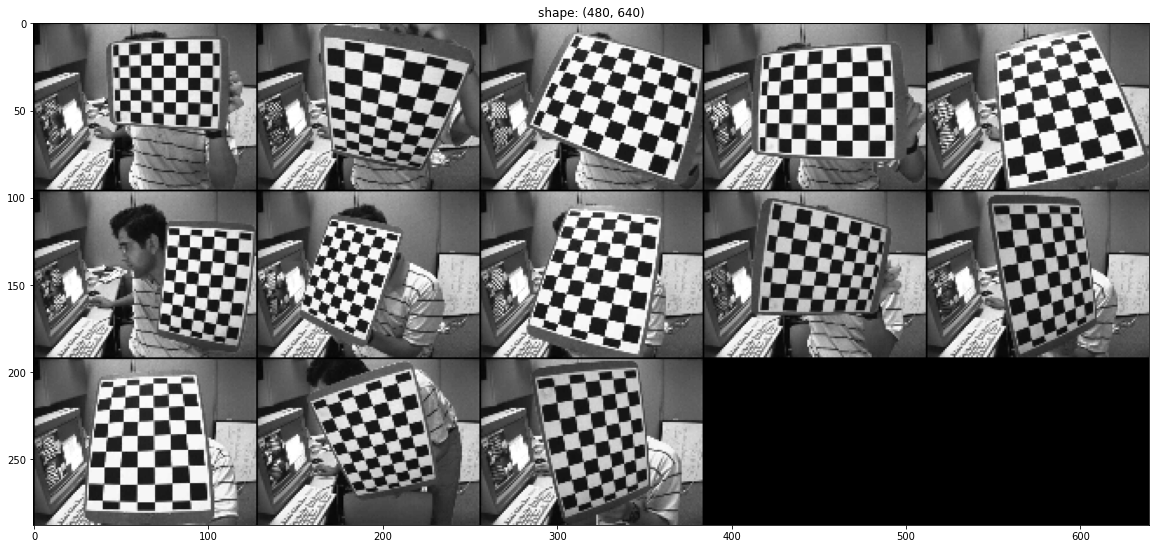

In [24]:
plt.subplots(1,1, figsize=(20,10))
plt.imshow(mosaic(images, 5), cmap="gray")
plt.title(f"shape: {images[0].shape}");

In [29]:
images = get_camera_images(DATA_DIR + "left*.jpg")

chessboard_correspondences = getChessboardCorners(images, visualize = True)
      

chessboard_correspondences_normalized = normalize_points(chessboard_correspondences)

print("M = ", len(chessboard_correspondences_normalized), " view images")
print("N = ", len(chessboard_correspondences_normalized[0][0]),  " points per image")

H = []
for correspondence in chessboard_correspondences_normalized:
    H.append(compute_view_based_homography(correspondence, reproj=0))

H_r = []
for i in range(len(H)):
    h_opt = refine_homographies(H[i], chessboard_correspondences_normalized[i], skip=False)
    H_r.append(h_opt)

A = get_intrinsic_parameters(H_r)
print(A)

# sys.exit(1)

Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Chessboard Detected 
Matrix: A : meanx 4.0, meany 2.5, varx 6.666666666666667, vary 2.9166666666666665, sx 0.5477225575051661, sy 0.828078671210825 
Matrix: B : meanx 374.8703703703704, meany 174.40740740740742, varx 7469.520233196159, vary 3432.611796982168, sx 0.016363215267945496, sy 0.02413807611794994 
Matrix: A : meanx 4.0, meany 2.5, varx 6.666666666666667, vary 2.9166666666666665, sx 0.5477225575051661, sy 0.828078671210825 
Matrix: B : meanx 367.4074074074074, meany 258.74074074074076, varx 6623.463648834019, vary 8112.969821673526, sx 0.01737690469737156, sy 0.015700918800122747 
Matrix: A : meanx 4.0, meany 2.5, varx 6.666666666666667, vary 2.9166666666666665, sx 0.5477225575051661, sy 0.828078671210825 
Matrix: B : meanx 399.7

p_model (0.5477225575051659, 1.2421180068162374) 	 p_obs (0.4763707386694662, 1.287265184334398)
p_model (1.0954451150103321, 1.2421180068162374) 	 p_obs (0.9643189523154865, 1.3289142675902736)
p_model (1.6431676725154984, 1.2421180068162374) 	 p_obs (1.4217704026086304, 1.37056335084615)
p_model (2.1908902300206643, 1.2421180068162374) 	 p_obs (1.8334767078724594, 1.3913878924740883)
p_model (-2.1908902300206643, 2.0701966780270626) 	 p_obs (-2.5428088332652843, 1.8911768915446032)
p_model (-1.6431676725154982, 2.0701966780270626) 	 p_obs (-1.9023768028548824, 1.953650516428418)
p_model (-1.0954451150103321, 2.0701966780270626) 	 p_obs (-1.2771931541209192, 1.9744750580563561)
p_model (-0.5477225575051661, 2.0701966780270626) 	 p_obs (-0.6977546504162699, 1.9952995996842944)
p_model (0.0, 2.0701966780270626) 	 p_obs (-0.14881291006449704, 2.0161241413122326)
p_model (0.5477225575051659, 2.0701966780270626) 	 p_obs (0.36963206693439865, 2.03694868294017)
p_model (1.0954451150103321, 2

V.b = 0 Solution :  (6,)
[235.75125989214268, 0.6146167066763762, 535.8598147226522, 537.4402658838006, -2.336413463888583, 351.7272705795895]
Intrinsic Camera Matrix is :
[[535.86   -2.336 351.727]
 [  0.    537.44  235.751]
 [  0.      0.      1.   ]]
[[535.86   -2.336 351.727]
 [  0.    537.44  235.751]
 [  0.      0.      1.   ]]
